In [1]:
!pip install pillow numpy torch opencv-python matplotlib seaborn torchvision tqdm scikit-learn umap-learn huggingface-hub git-lfs transformers

In [2]:
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

/home/ppxscal/miniconda3/envs/mit6300/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
from transformers import pipeline
from huggingface_hub import hf_hub_url, cached_download

REPO_NAME = 'ppxscal/cv_project'
X_FILE = 'X_tensor.pt'
Y_FILE = 'y_tensor.pt'

# Get the URL for each file
x_url = hf_hub_url(REPO_NAME, X_FILE)
y_url = hf_hub_url(REPO_NAME, Y_FILE)

# Download the files and cache them locally
x_cache = cached_download(x_url)
y_cache = cached_download(y_url)

# Load the tensors from the cached files
X = torch.load(x_cache)
y = torch.load(y_cache)

class_counts = y.bincount()
num_samples = y.size(0)
class_weights = 1. / class_counts

# Create a list of weights for each sample
sample_weights = class_weights[y]

# Set up the sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

# Create a dataset and a dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
# print(f'Corrupted images: {corrupted}')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # You can adjust this based on your specific needs

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders for both training and validation sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

# Starting the training and validation process
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader):  # Use train_loader for training
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():  # No gradient updates during validation
        for images, labels in tqdm(val_loader):  # Use val_loader for validation
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)
    
    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}% \n')

/home/ppxscal/miniconda3/envs/mit6300/lib/python3.12/site-packages/huggingface_hub/file_download.py:669: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
100%|██████████| 221/221 [00:01<00:00, 135.37it/s]


Epoch 1, Training Loss: 1.0442180215503296


100%|██████████| 56/56 [00:00<00:00, 304.24it/s]


Epoch 1, Validation Loss: 0.9397319353052548, Validation Accuracy: 55.56441326530612% 



100%|██████████| 221/221 [00:01<00:00, 159.82it/s]


Epoch 2, Training Loss: 0.8866308385430418


100%|██████████| 56/56 [00:00<00:00, 347.50it/s]


Epoch 2, Validation Loss: 0.7643497575606618, Validation Accuracy: 66.43016581632654% 



100%|██████████| 221/221 [00:01<00:00, 158.55it/s]


Epoch 3, Training Loss: 0.6954714730044835


100%|██████████| 56/56 [00:00<00:00, 366.68it/s]


Epoch 3, Validation Loss: 0.6392521166375705, Validation Accuracy: 68.88552295918367% 



100%|██████████| 221/221 [00:01<00:00, 153.76it/s]


Epoch 4, Training Loss: 0.45784013600371004


100%|██████████| 56/56 [00:00<00:00, 363.70it/s]


Epoch 4, Validation Loss: 0.4269543332712991, Validation Accuracy: 81.94355867346938% 



100%|██████████| 221/221 [00:01<00:00, 157.77it/s]


Epoch 5, Training Loss: 0.24790819923127938


100%|██████████| 56/56 [00:00<00:00, 369.10it/s]


Epoch 5, Validation Loss: 0.23305740327175176, Validation Accuracy: 91.26275510204081% 



100%|██████████| 221/221 [00:01<00:00, 160.41it/s]


Epoch 6, Training Loss: 0.12008853625017324


100%|██████████| 56/56 [00:00<00:00, 354.17it/s]


Epoch 6, Validation Loss: 0.10279021515244884, Validation Accuracy: 96.42857142857143% 



100%|██████████| 221/221 [00:01<00:00, 153.77it/s]


Epoch 7, Training Loss: 0.06074818234882271


100%|██████████| 56/56 [00:00<00:00, 362.94it/s]


Epoch 7, Validation Loss: 0.16406577240143502, Validation Accuracy: 93.55070153061224% 



100%|██████████| 221/221 [00:01<00:00, 158.20it/s]


Epoch 8, Training Loss: 0.040731040618647886


100%|██████████| 56/56 [00:00<00:00, 356.33it/s]


Epoch 8, Validation Loss: 0.07210859732003883, Validation Accuracy: 97.06632653061224% 



100%|██████████| 221/221 [00:01<00:00, 157.70it/s]


Epoch 9, Training Loss: 0.01701708731917892


100%|██████████| 56/56 [00:00<00:00, 366.39it/s]


Epoch 9, Validation Loss: 0.09662930188434464, Validation Accuracy: 96.56409438775509% 



100%|██████████| 221/221 [00:01<00:00, 156.82it/s]


Epoch 10, Training Loss: 0.006114127596932973


100%|██████████| 56/56 [00:00<00:00, 351.19it/s]

Epoch 10, Validation Loss: 0.025255137878307972, Validation Accuracy: 99.05133928571429% 



8831 (8831, 4) (4,) 8831
(8831, 2)


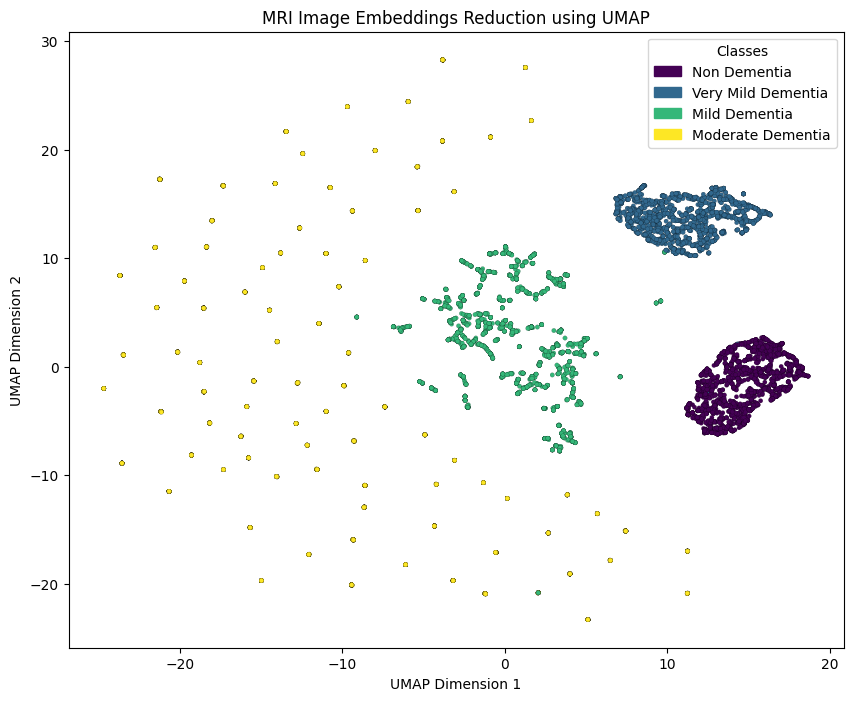

In [5]:
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.unsqueeze(1).to(device)
        emb = model(images)
        # print(F.softmax(emb, dim=0))
        embeddings.append(emb.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.cm import plasma  # Import plasma colormap

labels_to_class = {
0: "Non Dementia",
1: "Very Mild Dementia",
2: "Mild Dementia",
3: "Moderate Dementia",
}
print(len(embeddings), embeddings.shape, embeddings[0].shape, len(labels_list))

# Perform UMAP reduction
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embeddings)
print(umap_embeddings.shape)
# umap_embeddings = umap_embeddings / np.linalg.norm(umap_embeddings, axis=1)
cmap = plt.cm.viridis

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels_list, cmap=cmap, s=10, edgecolor='black', linewidth=0.1)
# Create a legend
legend_handles = [mpatches.Patch(color=cmap(i / (len(labels_to_class) - 1)), label=labels_to_class[i]) for i in labels_to_class]
plt.legend(handles=legend_handles, title="Classes")

plt.title('MRI Image Embeddings Reduction using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()